<a href="https://colab.research.google.com/github/irynagorbenko/data-science/blob/opi-radiomics/plan_badan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DLA WSZYSTKICH: podzielić na PZ i TZ. Analizy robimy osobno dla różnych stref - 4 regresji

I. rozroznienie rak/nie rak

1. TBx_SBx_state =1, 0 (N/A odrzucamy) - kliniczny
2. podzielić na PZ i TZ - radiologiczny
3. regresja wg cech radiomicznych

nr of study = 


II. rozruzniamy isup (1 -5) dla rakowych pacjentow (isup_group)

1. TBx_SBx_state =1
2. no_of_possitive = 1
3. podzielić na PZ i TZ - radiologiczny
4. regresja wg cech radiomicznych / klasyfikator (lasy losowe)

nr of study = 

In [ ]:
!pip install pingouin

In [2]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns

In [3]:
# Read data from CSV
clinDF = pd.read_csv('/content/AI4A4_PCa_clinical.csv')
srDF = pd.read_csv('/content/AI4AR_PCa_radiological.csv')
radDF = pd.read_csv('/content/radiomics_t2w.csv')

In [4]:
print(clinDF.shape, radDF.shape, srDF.shape)

(503, 47) (1046, 47) (1464, 21)


In [5]:
clinDF.columns = clinDF.columns.str.replace(' ', '')

In [6]:
# Get studies where TBx_SBx_state =1, 0 (true positive, true negative cancer)

clinDF = clinDF[clinDF['TBx_SBx_state'].notna()]
clinDF.shape

# Get studies where TBx_SBx_state = 0
clinDF0 = clinDF[clinDF['TBx_SBx_state']==0]

# Get studies where TBx_SBx_state = 1
clinDF1 = clinDF[clinDF['TBx_SBx_state']==1]

In [7]:
# Divide to PZ and TZ lesions

# PZ
srDF[['patient_id', 'lesion_originating']].head(10)
srDF_PZ = srDF[srDF['lesion_originating'] == 'PZ']
srDF_PZ.shape

(699, 21)

In [8]:
# TZ
srDF_TZ = srDF[srDF['lesion_originating'] == 'TZ']
srDF_TZ.shape

(765, 21)

In [ ]:
# Prepare studies in PZ

id_PZ = srDF_PZ[['patient_id']].drop_duplicates()
id_PZ.shape

# Studies where TBx_SBx_state =1 (aimed biopsy is positive, systematic is not important) - true positive, cancer
clinDF_PZ1 = clinDF1[clinDF1['patient_id'].isin(id_PZ['patient_id'])]
clinDF_PZ1

# Studies where TBx_SBx_state =0 (aimed biopsy is negative, systematic is negative) - true negative, healthy
clinDF_PZ0 = clinDF0[clinDF0['patient_id'].isin(id_PZ['patient_id'])]
clinDF_PZ0


In [ ]:
# Prepare studies in TZ

id_TZ = srDF_TZ[['patient_id']].drop_duplicates()
id_TZ.shape

# Studies where TBx_SBx_state =1 (aimed biopsy is positive, systematic is not important) - true positive, cancer
clinDF_TZ1 = clinDF1[clinDF1['patient_id'].isin(id_TZ['patient_id'])]
clinDF_TZ1

# Studies where TBx_SBx_state =0 (aimed biopsy is negative, systematic is negative) - true negative, healthy
clinDF_TZ0 = clinDF0[clinDF0['patient_id'].isin(id_TZ['patient_id'])]
clinDF_TZ0

# **Statistic analysis in PZ - test on PSA results**

## **Prepare learning and test groups**

In [11]:
# Prepare learning group and test group in PZ

healthy = clinDF_PZ0.shape[0]
healthy

sick = clinDF_PZ1.shape[0]
sick

totalNR = healthy + sick
# totalNR*0.8 # 146 studies

# healthy*0.8 # 40 studies - 80 %

# sick*0.8 # 106 studies - 80 %

In [ ]:
# Test of the approach - does psa predict cancer?

'psa_result'
'psa_result', 'prostate_volume_us',
       'psa_density_us', 'prostate_volume_mri', 'psa_density_mri'


       'is_cancer'

       'gs_primary', 'gs_secondary', 'gs_total', 'isup_group', 'gs_post',
       'isup_grade_post'
clinDF_PZ0.columns

## **Preprocessing of the data - test on PSA results**

In [ ]:
# Create new dataframe where psa results for healthy and ill subjects are presented in different columns (healthy pacients are less then ill)

# Healthy subjects
c1 = clinDF_PZ0[['psa_result']].astype('float').reset_index()
c1.columns = ['index_PZ0', 'psa_result_PZ0']
c1.columns

# Subjects with cancer
c2 = clinDF_PZ1[['psa_result']].astype('float').reset_index()
c2.columns = ['index_PZ1', 'psa_result_PZ1']
c2

df = c2.join(c1)
df.info()

In [ ]:
df[['psa_result_PZ0', 'psa_result_PZ1']]. dtypes

## **Boxplots - PSA**

In [ ]:
# Set the figure size
plt.rcParams["figure.figsize"] = [10.50, 5.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = df[['psa_result_PZ0', 'psa_result_PZ1']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

## **Normality tests - PSA**

If the p-value of the test is greater than α = .05, then the data is assumed to be normally distributed.

In [ ]:
# Shapiro-Wilk Test

import math
import numpy as np
from scipy.stats import shapiro 

health_shapiro = shapiro(c1[['psa_result_PZ0']])
cancer_shapiro = shapiro(c2[['psa_result_PZ1']])
# According to Shapiro-Wilk test results are not normally distributed

In [ ]:
# Kolmogorov-Smirnov Test

import math
import numpy as np
from scipy.stats import kstest

#perform Kolmogorov-Smirnov test for normality
health_kstest = kstest(c1[['psa_result_PZ0']], 'norm')
cancer_kstest = kstest(c2[['psa_result_PZ1']], 'norm')

# According to Shapiro-Wilk test results are not normally distributed
health_kstest

## **Outliers detection - PSA**

**IQR (Inter Quartile Range)**

IQR = Quartile3 – Quartile1

upper = Q3 +1.5*IQR
lower = Q1 – 1.5*IQR

To define the outlier base value is defined above and below datasets normal range namely Upper and Lower bounds, define the upper and the lower bound

In [ ]:
stats = df.describe()[['psa_result_PZ0', 'psa_result_PZ1']]
stats

In [ ]:
stats.loc['count']

In [ ]:
clinDF_PZ0[['psa_result']] = clinDF_PZ0[['psa_result']].astype('float')

#Changing the outlier markers
red_circle = dict(markerfacecolor='red', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
plt.boxplot(x = clinDF_PZ0[['psa_result']], vert = True, flierprops=red_circle, showmeans=True, meanprops=mean_shape);

In [ ]:
clinDF_PZ = clinDF[clinDF['patient_id'].isin(id_PZ['patient_id'])]
clinDF_PZ.shape

cancer = clinDF_PZ[clinDF_PZ['is_cancer'].astype('bool')==True]
cancer

nocancer = clinDF_PZ[clinDF_PZ['is_cancer'].astype('bool')==False]
nocancer

In [ ]:
cancer[['psa_result']] = cancer[['psa_result']].astype('float')
nocancer[['psa_result']] = nocancer[['psa_result']].astype('float')

data = pd.DataFrame({"Cancer": cancer['psa_result'], "NoCancer": nocancer['psa_result']}, index=[0])

# Plot the dataframe
ax = data[['Cancer', 'NoCancer']].plot(kind='box', title='boxplot')



# **Statistic analysis of radiomic features**

## **Firstorder**

First-order statistics describe the distribution of voxel intensities within the image region defined by the mask through commonly used and basic metrics.

### **Preprocessing**

In [12]:
radDF_PZ0 = radDF[radDF['patient_id'].isin(clinDF_PZ0['patient_id'])]
radDF_PZ0

radDF_PZ1 = radDF[radDF['patient_id'].isin(clinDF_PZ1['patient_id'])]
radDF_PZ1

# Get only firstorder features for studies with cancer and no cancer in PZ area
radDF_PZ0_fo = radDF_PZ0[radDF_PZ0.columns[radDF_PZ0.columns.str.contains('original_firstorder')]]
radDF_PZ1_fo = radDF_PZ1[radDF_PZ1.columns[radDF_PZ1.columns.str.contains('original_firstorder')]]

# Add column 'patient_id'
radDF_PZ0_fo.insert(0, 'patient_id', radDF_PZ0.patient_id)
radDF_PZ1_fo.insert(0, 'patient_id', radDF_PZ1.patient_id)

# Add column 'is_cancer'
radDF_PZ0_fo.insert(1, 'is_cancer', 0)
radDF_PZ1_fo.insert(1, 'is_cancer', 1)

In [133]:
# DEBUG
from google.colab import files
radDF_PZ0_fo.to_csv('radDF_PZ0_fo.csv') 
files.download('radDF_PZ0_fo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Reset indexes for dataframes

radDF_PZ0_fo = radDF_PZ0_fo.reset_index(drop=True)
radDF_PZ1_fo = radDF_PZ1_fo.reset_index(drop=True)

In [ ]:
# DEBUG
a = random.sample(range(0, radDF_PZ0_fo.shape[0]-1), int(radDF_PZ0_fo.shape[0]*0.8//1))
import numpy as np
a = np.array(a)
np.sort(a)
a.shape

In [14]:
# Randomize 80 % of stadies for lerning group

# Randomize indexes
import random
import numpy as np

idxs_PZ0 = random.sample(range(0, radDF_PZ0_fo.shape[0]-1), int(radDF_PZ0_fo.shape[0]*0.8//1))
idxs_PZ1 = random.sample(range(0, radDF_PZ1_fo.shape[0]-1), int(radDF_PZ1_fo.shape[0]*0.8//1))
print(len(idxs_PZ0), len(idxs_PZ1))

# Sort indexes
idxs_PZ0 = np.sort(idxs_PZ0)
idxs_PZ1 = np.sort(idxs_PZ1)

# Get studies according to randomized indexes - LDF - Learning Data Frame
radDF_PZ0_fo_LDF = radDF_PZ0_fo.iloc[idxs_PZ0]
radDF_PZ1_fo_LDF = radDF_PZ1_fo.iloc[idxs_PZ1]
# Merge dataframes
radDF_PZ_fo_LDF = pd.concat([radDF_PZ0_fo_LDF, radDF_PZ1_fo_LDF], ignore_index=True, sort=False)
# shuffle the DataFrame rows
radDF_PZ_fo_LDF = radDF_PZ_fo_LDF.sample(frac = 1)

71 362


In [142]:
# DEBUG
from google.colab import files
radDF_PZ_fo_LDF.to_csv('radDF_PZ_fo_LDF.csv') 
files.download('radDF_PZ_fo_LDF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Simple logistic regression**

In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [16]:
# Data exploration
radDF_PZ_fo_LDF['is_cancer'].value_counts()

1    362
0     71
Name: is_cancer, dtype: int64

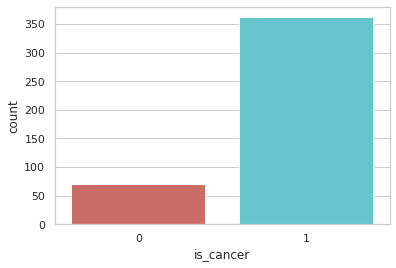

In [18]:
sns.countplot(x='is_cancer', data=radDF_PZ_fo_LDF, palette='hls')
plt.show()
# plt.savefig('count_iscancer_plot')

In [19]:
count_nocancer = len(radDF_PZ_fo_LDF[radDF_PZ_fo_LDF['is_cancer']==0])
count_cancer = len(radDF_PZ_fo_LDF[radDF_PZ_fo_LDF['is_cancer']==1])
pct_nocancer = count_nocancer/(count_nocancer + count_cancer)
print('percentage of healthy subjects: ', pct_nocancer)
pct_cancer = count_cancer/(count_nocancer + count_cancer)
print('percentage of subjects with cancer: ', pct_cancer)

# Our classes are imbalanced, and the ratio of subjects with cancer to healthy subjects is 84:16.

percentage of healthy subjects:  0.16397228637413394
percentage of subjects with cancer:  0.836027713625866


In [27]:
temp = radDF_PZ_fo_LDF.groupby('is_cancer').mean()
temp.drop('patient_id', axis=1)

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance
is_cancer,,,,,,,,,,,,,,,,,,
0,106.825352,255.280282,1.852955e+07,3.139978,70.661972,5.300290,433.845070,47.276153,178.492282,172.767606,30.014085,403.830986,30.061052,190.816232,0.774419,4.869897e+07,0.147377,4559.393406
1,94.185912,222.219890,1.995751e+07,3.002675,62.869475,5.459664,408.947514,41.037550,156.354701,152.241713,22.309392,386.638122,26.751583,166.335416,0.705553,4.703243e+07,0.157495,3224.922692


In [29]:
temp = radDF_PZ_fo_LDF.groupby('is_cancer').median()
temp.drop('patient_id', axis=1)

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance
is_cancer,,,,,,,,,,,,,,,,,,
0,106.0,249.7,8411385.0,3.216767,70.75,4.846854,427.0,48.124766,185.546218,180.00,0.0,386.0,29.938045,193.412378,0.921271,2.394685e+07,0.131568,4030.291211
1,88.1,219.8,10613038.0,2.983773,59.75,4.615059,386.5,38.640567,156.471738,151.75,0.0,375.5,25.337122,166.041876,0.686233,2.373211e+07,0.153945,2728.310543


In [31]:
radDF_PZ_fo_LDF

,patient_id,is_cancer,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance
118,210,1,106.6,270.8,6191252.0,2.979366,72.5,4.596738,417.0,49.175841,170.235294,153.0,76.0,341.0,31.664970,181.956862,1.343892,1.795705e+07,0.160399,4128.244102
74,3,1,63.0,201.0,2243638.0,3.056317,57.0,3.340976,286.0,41.261253,125.123967,115.0,8.0,278.0,27.283027,136.170712,0.634257,4.263823e+06,0.148009,2886.455707
127,233,1,58.0,136.0,25675402.0,2.450442,37.0,9.177275,382.0,25.126866,97.465388,95.0,0.0,382.0,16.134119,103.474667,1.228623,4.879368e+07,0.227246,1207.504849
30,323,0,155.0,250.1,25243145.0,2.727702,52.0,3.834079,351.0,31.335711,201.138333,199.0,38.0,313.0,21.676653,205.114379,0.147349,7.321498e+07,0.180911,1615.279197
188,483,1,152.4,217.2,907294.0,2.243216,38.0,2.744760,251.0,22.217600,188.480000,185.0,135.0,116.0,14.326870,190.503963,0.133436,2.631507e+06,0.238400,767.049600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1085,1,42.0,171.0,23905865.0,3.079060,68.0,9.806569,543.0,42.087012,104.248378,99.0,0.0,543.0,28.241821,118.759232,1.508491,4.543085e+07,0.139524,3236.030934
256,711,1,67.2,268.2,18010788.0,3.660294,99.0,3.680230,515.0,62.705176,167.040153,162.0,0.0,515.0,41.769934,185.573309,0.528347,3.627661e+07,0.092462,6535.040453
104,159,1,97.0,281.4,20433698.0,3.538984,89.0,3.782073,480.0,56.254861,180.893855,175.0,0.0,480.0,37.362622,195.068140,0.570950,5.926571e+07,0.104155,5328.992458
126,218,1,144.0,217.8,2495746.0,2.369231,29.0,5.171227,293.0,24.539016,174.506329,166.0,104.0,189.0,14.888184,177.740602,1.269779,7.238639e+06,0.240827,1139.262618


In [33]:
# Balancing the data - Over-sampling using SMOTE

X = radDF_PZ_fo_LDF.loc[:, radDF_PZ_fo_LDF.columns != 'is_cancer']
y = radDF_PZ_fo_LDF.loc[:, radDF_PZ_fo_LDF.columns == 'is_cancer']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['is_cancer'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['is_cancer']==0]))
print("Number of subscription",len(os_data_y[os_data_y['is_cancer']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['is_cancer']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['is_cancer']==1])/len(os_data_X))

length of oversampled data is  512
Number of no subscription in oversampled data 256
Number of subscription 256
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [35]:
# Recursive Feature Elimination

radDF_PZ_fo_LDF_vars=radDF_PZ_fo_LDF.columns.values.tolist()
y=['is_cancer']
X=[i for i in radDF_PZ_fo_LDF_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, step = 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True False False False  True False  True  True False
  True False  True False  True False  True]
[2 2 1 1 2 2 2 1 2 1 1 2 1 2 1 2 1 2 1]


In [36]:
radDF_PZ_fo_LDF_vars

Usunac patient_id', 'is_cancer', z wektora X

['patient_id',
 'is_cancer',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance']